In [1]:
import sys
import os

sys.path.append(os.path.abspath("../analysis"))


import opc
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from Surface import InterdigitationAnalysis
import order
import logging

In [2]:
u = mda.Universe('../../../../../mlx_v2/6.6_2.gro', '../../../../../mlx_v2/old_trajs/rep1_skip10.xtc')

In [13]:
drude = mda.Universe('/mnt/d/trajs/ld.psf', '/mnt/d/eq_total_late.dcd')

In [29]:
halfz = u.dimensions[2] / 2
selection = f"resname POPC and (around 10 protein) and prop z > {halfz}"
start_frame = 980
end_frame = 1000

POPC1_protein_results = order.run_op(
    u,
    opc,  
    "POPC1", 
    selection=selection, 
    start_frame=start_frame, 
    end_frame=end_frame, 
    output_text='POPC1_near_protein.dat'
)


In [13]:
selection = f"resname POPC and (around 30 protein) and (not around 20 protein) and prop z > {halfz}"
start_frame = 980
end_frame = 1000 

POPC1_protein_results = order.run_op(
    u,
    opc,  
    "POPC1", 
    selection=selection, 
    start_frame=start_frame, 
    end_frame=end_frame, 
    output_text='POPC1_far_protein.dat'
)

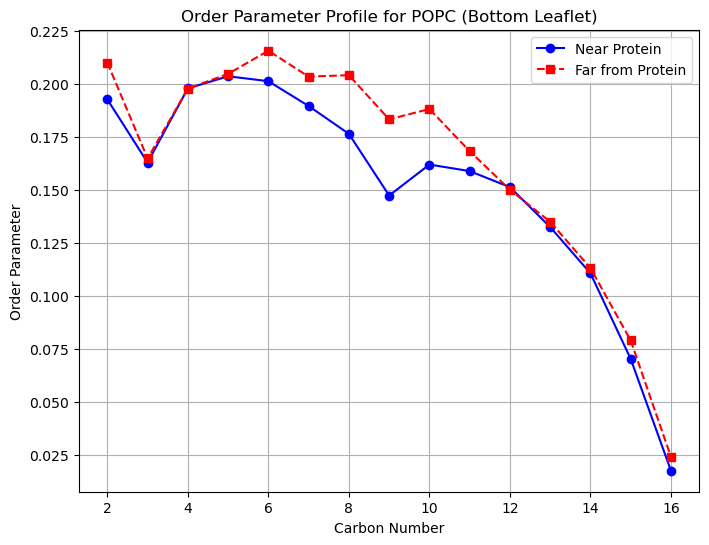

In [14]:

POPC1_far = np.loadtxt('POPC1_far.dat')
POPC1_near_protein = np.loadtxt('POPC1_near_protein.dat')

# Extract carbon numbers and order parameters from each file
carbon_numbers_near = POPC1_near_protein[:, 0]
order_parameters_near = POPC1_near_protein[:, 1]

carbon_numbers_far = POPC1_far[:, 0]
order_parameters_far = POPC1_far[:, 1]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(carbon_numbers_near, order_parameters_near, marker='o', linestyle='-', color='b', label='Near Protein')
plt.plot(carbon_numbers_far, order_parameters_far, marker='s', linestyle='--', color='r', label='Far from Protein')

plt.xlabel('Carbon Number')
plt.ylabel('Order Parameter')
plt.title('Order Parameter Profile for POPC (Bottom Leaflet)')
plt.legend()
plt.grid(True)
plt.show()


# For SURF-TG


In [21]:
import logging

logger = logging.getLogger(__name__)

interdig_analysis = InterdigitationAnalysis(u, lipids=['POPC', 'DOPE', 'SAPI'], NL='TRIO', water='TIP3')
results_u = interdig_analysis.interdigit(b=100, e=120)
strong_u = results_u['strong_residues']

start_frame = 100
def get_dynamic_strong_residues(ts, name=strong_u, start_frame=start_frame):
    current_frame = ts.frame - start_frame
    if 0 <= current_frame < len(name):
        residues = name[current_frame]
        logger.info(f"Frame {ts.frame}: Strong residues = {residues}")
        return residues
    else:
        logger.info(f"Frame {ts.frame}: No strong residues available.")
        return []

OP_results = order.run_op(
    u,
    opc,
    lipid_selection='TRIO3',
    selection=None,
    start_frame=start_frame,
    end_frame=120,
    output_text='surf_test.dat',
    get_strong_residues=get_dynamic_strong_residues
)


Processing frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.16frame/s]


units: Z (nm), interdigitation (nm), time (ns), density (g/m3)


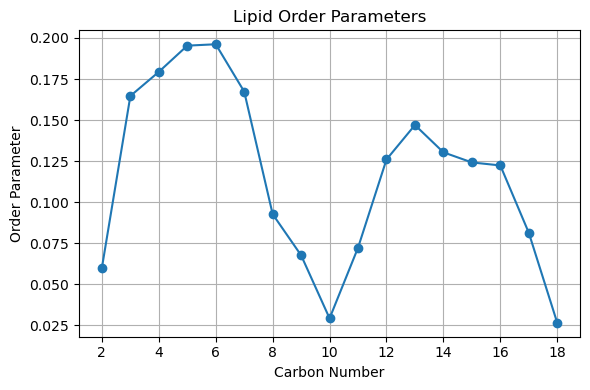

In [25]:
x_values = OP_results[:, 0]
y_values = OP_results[:, 1]

plt.figure(figsize=(6,4))
plt.plot(x_values, y_values, marker='o')
plt.xlabel('Carbon Number')
plt.ylabel('Order Parameter')
plt.title('Lipid Order Parameters')
plt.grid(True)
plt.tight_layout()
plt.show()

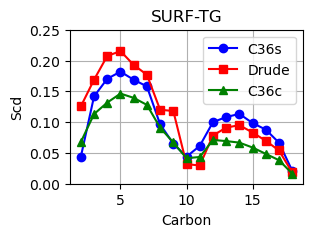

In [6]:
def plot_surf(u1='surf_c36s.dat', u2='surf_drude.dat', u3='surf_c36c.dat'):
    surf1 = np.loadtxt(u1)
    surf2 = np.loadtxt(u2)
    surf3 = np.loadtxt(u3)  

    carbon_numbers = surf1[:, 0]
    op1 = surf1[:, 1]
    op2 = surf2[:, 1]
    op3 = surf3[:, 1]

    # Plot the data
    plt.figure(figsize=(3, 2)) 
    plt.plot(carbon_numbers, op1, marker='o', linestyle='-', color='b', label='C36s')
    plt.plot(carbon_numbers, op2, marker='s', linestyle='-', color='r', label='Drude')
    plt.plot(carbon_numbers, op3, marker='^', linestyle='-', color='g', label='C36c')
    plt.xlabel('Carbon')
    plt.ylabel('Scd')
    plt.title('SURF-TG')
    plt.ylim(0,0.25)
    plt.legend()
    plt.grid(True)
    plt.savefig('order_tg.png',dpi=600, bbox_inches='tight')
    plt.show()

# Call the function with file names
u1 = 'surf_c36s.dat'
u2 = 'surf_drude.dat'
u3 = 'surf_c36c.dat'

plot_surf(u1, u2, u3)


In [19]:
pwd

'/mnt/c/users/jay/desktop/modules/v1_lipid_analysis/notebooks/surface_properties/surface_properties/examples'

In [3]:
angles, time_series, avg_op, std_op = order.run_vec_leaflet(
    universe=u,
    frame_start=0,
    frame_end=1000,
    frame_step=10,
    residue_sel="resname TRIO",
    tail_names=["C118", "C218", "C318"],
    headgroup_sel="name O*",
    pl_selection="resname POPC DOPE and name C210",
    leaflet='bottom',
    expected_headgroup_count=6
)


Analyzing rep1_skip10.xtc: 100%|██████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.76it/s]


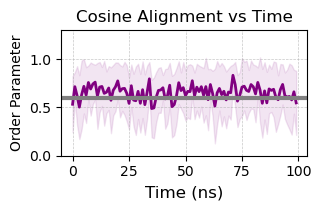

In [18]:
tail_names = ["C118", "C218", "C318"]
avg_values_combined = np.nanmean([np.array(avg_op[tail]) for tail in tail_names], axis=0)
std_values_combined = np.nanmean([np.array(std_op[tail]) for tail in tail_names], axis=0)
time_series_array = np.array(time_series)
valid_mask = ~np.isnan(avg_values_combined)

# Create plot
plt.figure(figsize=(3.4, 2.2))
plt.plot(
    time_series_array[valid_mask] / 10,  # convert to ns
    avg_values_combined[valid_mask],
    color='purple',
    linewidth=2
)
plt.fill_between(
    time_series_array[valid_mask] / 10,
    avg_values_combined[valid_mask] - std_values_combined[valid_mask],
    avg_values_combined[valid_mask] + std_values_combined[valid_mask],
    color='purple',
    alpha=0.1
)

plt.axhline(0.6, color='gray', linestyle='-', linewidth=3)

plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Order Parameter", fontsize=10)
plt.title("Cosine Alignment vs Time", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()
